In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx
import numpy as np

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_intervals import load_graphs
from src.pass_networks.pass_network import calculate_metrics 
from src.pass_networks.custom_metrics import calculate_average_path_legth_target
from src.pass_networks.custom_metrics import calculate_wasserstein_distance
from src.pass_networks.custom_metrics import calculate_modularity
from src.pass_networks.custom_metrics import calculate_graph_distance_stream

# Get Graphs

In [5]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [6]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 175


In [7]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches += match_graphs

Loading Graphs:   0%|          | 0/175 [00:00<?, ?it/s]

In [8]:
matches_df = pd.DataFrame(matches)
matches_df

,match_id,interval_id,team_id,graph
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
...,...,...,...,...
17225,4625,48.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
17226,4625,49.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"
17227,4625,49.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
17228,4625,50.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"


# Graph Stream

In [9]:
distance_metrics = {    
    "Wasserstein": calculate_wasserstein_distance
}

In [10]:
df_sorted = matches_df.sort_values(by=['match_id', 'team_id', 'interval_id']).reset_index(drop=True)
df_sorted.head()

,match_id,interval_id,team_id,graph
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"


In [11]:
# Lista para armazenar os resultados
distance_data = []

# Itera sobre os grupos de 'match_id' e 'team_id'
for (match_id, team_id), group in tqdm(df_sorted.groupby(['match_id', 'team_id']), desc="Calculating Distances", total=len(df_sorted.groupby(['match_id', 'team_id']))):
    # Ordena o grupo por 'interval_id'
    group = group.sort_values(by='interval_id').reset_index(drop=True)
    # Itera sobre os pares de grafos consecutivos
    for i in range(len(group) - 1):
        current_row = group.iloc[i]
        next_row = group.iloc[i + 1]
        # Verifica se os 'interval_id' são consecutivos
        distances = {'match_id': match_id, 'team_id': team_id, 'interval_id': current_row['interval_id']}
        G1 = current_row['graph']
        G2 = next_row['graph']
        # Calcula cada métrica de distância
        for metric_name, metric_fn in distance_metrics.items():
            distances[metric_name] = metric_fn(G1, G2)
        distance_data.append(distances)

# Cria o novo DataFrame com as métricas de distância
df_distances = pd.DataFrame(distance_data)
df_distances

Calculating Distances:   0%|          | 0/350 [00:00<?, ?it/s]

,match_id,team_id,interval_id,Wasserstein
0,4436,2,1.0,0.666667
1,4436,2,2.0,2.166667
2,4436,2,3.0,1.833333
3,4436,2,4.0,0.666667
4,4436,2,5.0,0.666667
...,...,...,...,...
16875,4625,221,45.0,1.500000
16876,4625,221,46.0,0.166667
16877,4625,221,47.0,0.333333
16878,4625,221,48.0,0.500000


# Optimization

In [12]:
from src.concept_drift.drift_points import detect_kswin_drift
import numpy as np

In [13]:
from src.concept_drift.syntethic_graphs import generate_synthetic_data
from src.concept_drift.syntethic_graphs import draw_synthetic_data
from src.concept_drift.optimization import optimize_drift_parameters

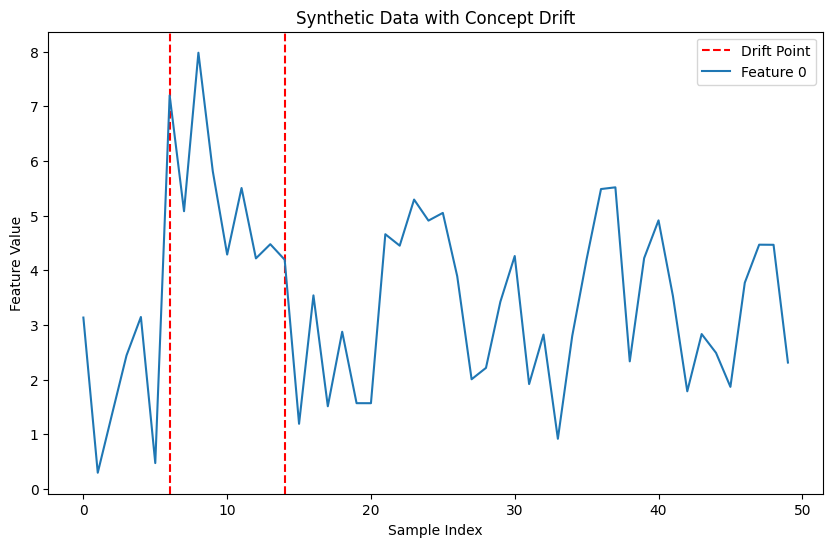

In [14]:
# Generate the dataset
synthetic_data, expected_drift_points = generate_synthetic_data(n_samples=50, n_drifts=2)
draw_synthetic_data(synthetic_data, expected_drift_points)

In [15]:
# KSWIN Parameter Grid
kswin_param_grid = {
    'a': [0.001, 0.005, 0.01, 0.05, 0.1],
    'ws': [4, 6, 8, 10, 12, 15, 20],
    'ss': [1, 2, 3, 4, 5],
    'seed': [42]
}

# Optimize KSWIN
kswin_results_2 = optimize_drift_parameters(detect_kswin_drift, synthetic_data, expected_drift_points, kswin_param_grid)
kswin_results_2.sort_values(by=['recall','false_positive_rate','f1_score','delay'], ascending=[False,True,False,True])
#print("KSWIN Optimization Results:", kswin_results)

TypeError: optimize_drift_parameters() takes from 2 to 3 positional arguments but 4 were given

In [19]:
# KSWIN Parameter Grid
kswin_param_grid = {
    'a': [0.001, 0.005, 0.01, 0.05, 0.1],
    'ws': [4, 6, 8, 10, 12, 15, 20],
    'ss': [1, 2, 3, 4, 5],
    'seed': [42]
}

# Optimize KSWIN
kswin_results = optimize_drift_parameters(detect_kswin_drift, kswin_param_grid)
kswin_results.sort_values(by=['recall','false_positive_rate','f1_score','delay'], ascending=[False,True,False,True], inplace=True)

kswin_results['params'] = kswin_results['params'].astype(str)

grouped = kswin_results.groupby(['id_params']).agg(
    recall_mean=('recall', 'mean'),
    fpr_mean=('false_positive_rate', 'mean'),
    f1_mean=('f1_score', 'mean'),
    delay_mean=('delay', 'mean'),
    precision_mean=('precision', 'mean')
).reset_index()
grouped.sort_values(by=['recall_mean','fpr_mean','f1_mean','delay_mean'], ascending=[False,True,False,True], inplace=True)

grouped = grouped.merge(kswin_results[['id_params', 'params']].drop_duplicates(), on='id_params', how='left')

grouped

,id_params,recall_mean,fpr_mean,f1_mean,delay_mean,precision_mean,params
0,156,0.833333,0.472222,0.641270,7.777778,0.527778,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 8}"
1,155,0.722222,0.700000,0.411111,10.750000,0.300000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 6}"
2,157,0.666667,0.583333,0.507937,8.916667,0.416667,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}"
3,158,0.500000,0.722222,0.355556,8.944444,0.277778,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 12}"
4,171,0.277778,0.722222,0.277778,8.666667,0.277778,"{'a': 0.1, 'seed': 42, 'ss': 5, 'ws': 10}"
5,101,0.166667,0.750000,0.200000,3.500000,0.250000,"{'a': 0.01, 'seed': 42, 'ss': 5, 'ws': 10}"
6,136,0.166667,0.750000,0.200000,3.500000,0.250000,"{'a': 0.05, 'seed': 42, 'ss': 5, 'ws': 10}"
7,173,0.111111,0.833333,0.133333,8.666667,0.166667,"{'a': 0.1, 'seed': 42, 'ss': 5, 'ws': 15}"
8,159,0.111111,0.888889,0.111111,9.388889,0.111111,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 15}"
9,128,0.111111,0.888889,0.111111,11.722222,0.111111,"{'a': 0.05, 'seed': 42, 'ss': 4, 'ws': 8}"


In [254]:
best = grouped.merge(kswin_results[['id_params', 'params']], on='id_params')
best.head(20)

,id_params,recall_mean,fpr_mean,f1_mean,delay_mean,params
0,158,0.722222,0.166667,0.711111,4.000000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 12}"
1,158,0.722222,0.166667,0.711111,4.000000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 12}"
2,158,0.722222,0.166667,0.711111,4.000000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 12}"
3,157,0.722222,0.333333,0.611111,5.888889,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}"
4,157,0.722222,0.333333,0.611111,5.888889,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}"
5,157,0.722222,0.333333,0.611111,5.888889,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}"
6,155,0.722222,0.416667,0.546032,6.250000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 6}"
7,155,0.722222,0.416667,0.546032,6.250000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 6}"
8,155,0.722222,0.416667,0.546032,6.250000,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 6}"
9,159,0.444444,0.722222,0.333333,9.666667,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 15}"


In [239]:
kswin_results[kswin_results['id_params']==157]

,id_params,params,detected_drifts,expected_drifts,true_detection_rate,false_negative_rate,false_positive_rate,delay,precision,recall,f1_score
41,157,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}","[10, 29]","[10, 28]",1.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.0
15,157,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}","[13, 32, 44]",[11],1.000000,0.000000,0.666667,18.666667,0.333333,1.000000,0.5
68,157,"{'a': 0.1, 'seed': 42, 'ss': 3, 'ws': 10}",[20],"[6, 10, 19]",0.333333,0.666667,0.000000,1.000000,1.000000,0.333333,0.5
